In [1]:
import numpy as np
import pandas as pd
import os
import time
import pickle
import gzip

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline

from sklearn.metrics import accuracy_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Fashion MNIST dataset
- 28*28 pixels(784 차원)
- label
  - 0 T-shirt/top
  - 1 Trouser
  - 2 Pullover
  - 3 Dress
  - 4 Coat
  - 5 Sandal
  - 6 Shirt
  - 7 Sneaker
  - 8 Bag
  - 9 Ankle boot


In [3]:
#데이터 불러오기
fashion=pd.read_csv('/content/drive/MyDrive/DSL/세션/2월 2주차/[0207]_Dimensionality_Reduction/fashion-mnist.csv') #경로수정
fashion.head(3) #60000 rows

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


- (Q1) X_train, y_train, X_test, y_test 지정하기
  - 60000개의 전체 데이터셋 사용하지 않아도 됨 (학습 속도가 느려짐)
  - 본인이 생각하는 적절한 train 개수, test 개수를 설정하여 분리하도록
    - 이때 train과 test 데이터의 라벨 분포가 균등하게 이루어지도록 분리해야함(학습시에 편향되지 않도록)
    - 그래프 그려서 라벨값 분포가 균등한지 확인할 것

In [4]:
X = fashion.drop('label', axis = 1)
y = fashion['label']

In [7]:
from numpy.random import RandomState
import random

idx = np.arange(60000)
random.seed(2021)
random.shuffle(idx)

X_shuffled = X.iloc[idx].reset_index().drop('index', axis = 1)
y_shuffled = y[idx].reset_index().drop('index', axis = 1)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


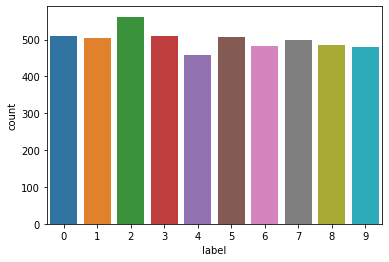

In [ ]:
#train dataset으로 5000개만 사용
X_train=X_shuffled.iloc[:5000,:]
y_train=y_shuffled[:5000]['label']

sns.countplot(y_train) # y라벨이 균등하게 분포하는지 확인
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


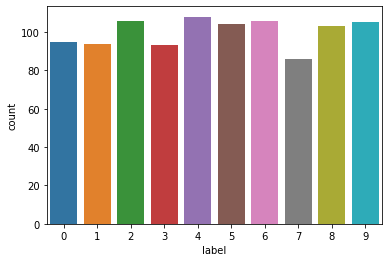

In [ ]:
#test dataset으로 1000개만 사용
X_test=X_shuffled.iloc[5000:6000,:]
y_test=y_shuffled[5000:6000]['label']
sns.countplot(y_test) # y라벨이 균등하게 분포하는지 확인
plt.show()

- 어떻게 생긴 데이터셋인지 확인해보기

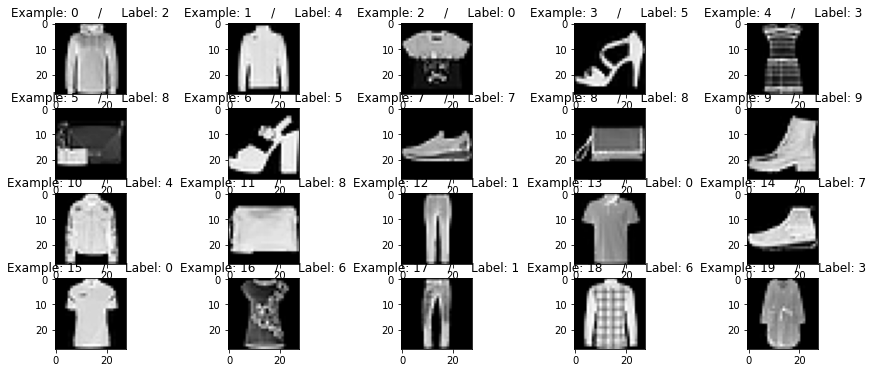

In [ ]:
plt.figure(figsize=(15,6))
for i in range(20):
  plt.subplot(4,5,i+1)
  label = y_train.iloc[i]
  image = X_train.iloc[i,:].values.reshape([28, 28])
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  plt.title('Example: %d     /     Label: %d'%(i, label))

plt.show()

# PCA를 활용해 성능 높여보기


- (Q2) 합리적인 잠재변수 개수 설정하기
  - PCA에서 각 잠재변수가 설명하는 분산 비율을 보고 적절한 잠재변수 개수 설정
  - 개수 설정 기준은 본인 재량. 다만, 명확한 기준을 서술할 것.

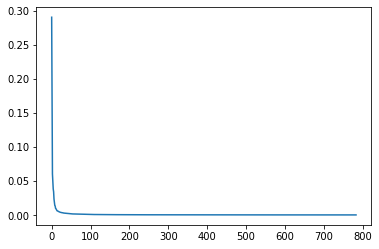

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 784)
X_train_pca = pca.fit_transform(X_train)

plt.plot(np.arange(784), pca.explained_variance_ratio_)
plt.show()

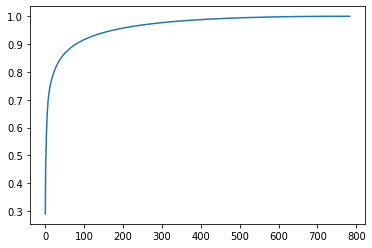

In [ ]:
cumm = 0
cumm_ratio = np.array([])
for ratio in pca.explained_variance_ratio_:
  cumm += ratio
  cumm_ratio = np.append(cumm_ratio, [cumm])

plt.plot(np.arange(len(cumm_ratio)), cumm_ratio)
plt.show()

In [ ]:
# 최소 분산의 85% 정도는 설명할 수 있는 변수 개수 선택
np.where(cumm_ratio > 0.85)[0][0]

41

- (Q3) 학습속도, 성능의 향상을 보이는지 확인
  - 기존에 배웠던 여러가지 classification model들 활용하기
  - 최소한 1가지 이상의 모델에 대해 비교해보고 차원축소 이전, 이후 어떠한 차이를 보이는지 서술


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

(5000, 42)


In [ ]:
# without PCA

import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

start = time.time()

no_pca_logit = LogisticRegression()
no_pca_logit.fit(X_train, y_train)

print('train accuracy:', accuracy_score(y_train, no_pca_logit.predict(X_train)))
print('test accuracy:', accuracy_score(y_test, no_pca_logit.predict(X_test)))

print(f'{time.time() - start}sec')

train accuracy: 0.9254
test accuracy: 0.789
5.078382968902588sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# with PCA

import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

start = time.time()

pca_logit = LogisticRegression()
pca_logit.fit(X_train_pca, y_train)

print('train accuracy:', accuracy_score(y_train, pca_logit.predict(X_train_pca)))
print('test accuracy:', accuracy_score(y_test, pca_logit.predict(X_test_pca)))

print(f'{time.time() - start}sec')

train accuracy: 0.8412
test accuracy: 0.816
0.7437343597412109sec


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 모델에 대해서 PCA를 이용한 차원축소 여부에 따라 비교해보았다.


차원 축소 이전에는 training 데이터에 대해서는 0.9254, test 데이터에 대해서는 0.789의 정확도를 가졌고 모델을 fit하는 데에는 약 5초가 걸렸다.
반면에 차원 축소 이후에는 training 데이터에 대한 정확도는 0.8442로 감소했지만 test 데이터에 대해서는 0.816로 증가한 것을 볼 수 있다. 게다가 모델을 fit하는 데에도 약 0.7초로 훨씬 적은 시간이 걸린 것을 확인할 수 있다.

# 2차원으로 시각화
- (Q4) 여러가지 차원 축소 방법 중 적절할 것으로 예상되는 방법 최소한 3가지 이용해서 시각화해보기
  - 하나의 차원 축소 방법도 하이퍼파라미터의 설정 다양하게 해보기
  - ex) KPCA에서 다양한 커널 함수 사용, ISOMAP or LLE에서 고려할 이웃의 개수 변경해보기

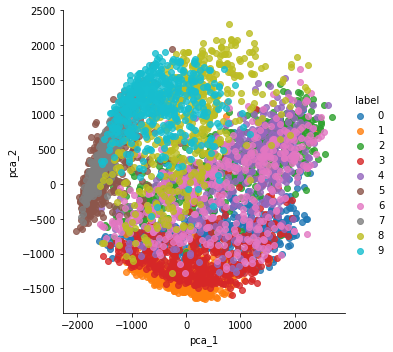

In [ ]:
# PCA

from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X_train_PCA = pca.fit_transform(X_train)

X_train_pca = pd.DataFrame(X_train_PCA)
X_train_pca = pd.concat((X_train_pca, y_train), axis=1)
X_train_pca.columns = ['pca_1', 'pca_2', 'label']

sns.lmplot(x = 'pca_1',y = 'pca_2', data=X_train_pca, hue = 'label', fit_reg = False)
plt.show()

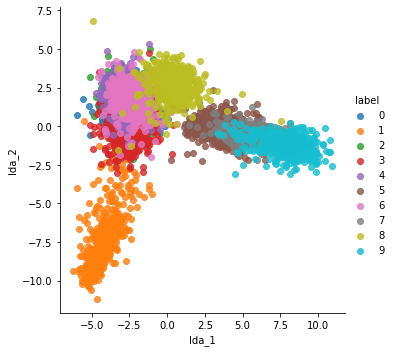

In [ ]:
# LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train) #차원축소 과정에 y라벨값을 입력해줌

X_train_lda = pd.DataFrame(X_train_lda)

X_train_lda = pd.concat((X_train_lda, y_train), axis=1) 
X_train_lda.columns = ['lda_1', 'lda_2', 'label']

sns.lmplot(x = 'lda_1', y = 'lda_2', data = X_train_lda, hue = 'label', fit_reg = False)
plt.show()

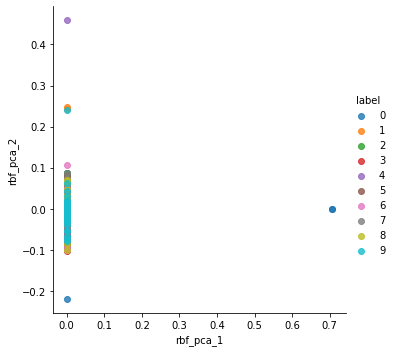

In [ ]:
# KPCA(rbf, 0.0433)

from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True) #방사형 커널 사용
X_train_rbf_pca=rbf_pca.fit_transform(X_train)

X_train_rbf_pca=pd.DataFrame(X_train_rbf_pca)
X_train_rbf_pca=pd.concat((X_train_rbf_pca, y_train), axis=1) 
X_train_rbf_pca.columns=['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x = 'rbf_pca_1', y = 'rbf_pca_2', data = X_train_rbf_pca, hue = 'label', fit_reg = False)
plt.show()

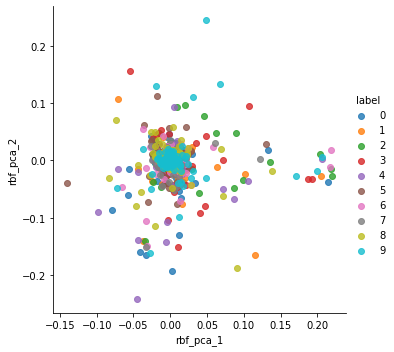

In [ ]:
# KPCA(rbf, 0.8)

from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.8, fit_inverse_transform = True) #방사형 커널 사용
X_train_rbf_pca = rbf_pca.fit_transform(X_train)

X_train_rbf_pca = pd.DataFrame(X_train_rbf_pca)
X_train_rbf_pca = pd.concat((X_train_rbf_pca, y_train), axis = 1) 
X_train_rbf_pca.columns = ['rbf_pca_1', 'rbf_pca_2', 'label']

sns.lmplot(x = 'rbf_pca_1', y = 'rbf_pca_2', data = X_train_rbf_pca, hue = 'label', fit_reg = False)
plt.show()

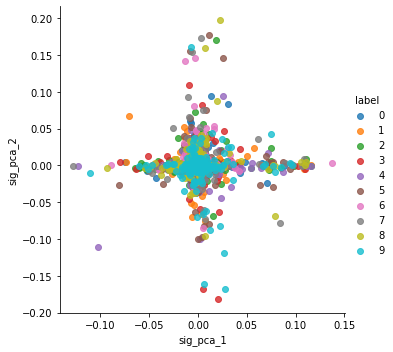

In [ ]:
# KPCA(sigmoid, 0.0433)

from sklearn.decomposition import KernelPCA

sig_pca = KernelPCA(n_components = 2, kernel = "sigmoid", gamma = 0.0433, fit_inverse_transform = True) #방사형 커널 사용
X_train_sig_pca = rbf_pca.fit_transform(X_train)

X_train_sig_pca = pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca = pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns = ['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x = 'sig_pca_1', y = 'sig_pca_2', data = X_train_sig_pca, hue = 'label', fit_reg = False)
plt.show()

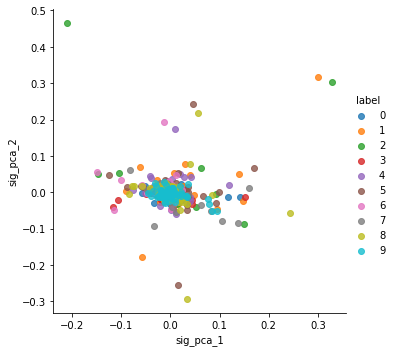

In [ ]:
# KPCA(sigmoid, 0.8)

from sklearn.decomposition import KernelPCA

sig_pca = KernelPCA(n_components = 2, kernel = "sigmoid", gamma = 0.8, fit_inverse_transform = True) #방사형 커널 사용
X_train_sig_pca = rbf_pca.fit_transform(X_train)

X_train_sig_pca = pd.DataFrame(X_train_sig_pca).loc[:,0:1]
X_train_sig_pca = pd.concat((X_train_sig_pca, y_train), axis=1) 
X_train_sig_pca.columns = ['sig_pca_1', 'sig_pca_2', 'label']

sns.lmplot(x = 'sig_pca_1', y = 'sig_pca_2', data = X_train_sig_pca, hue = 'label', fit_reg = False)
plt.show()

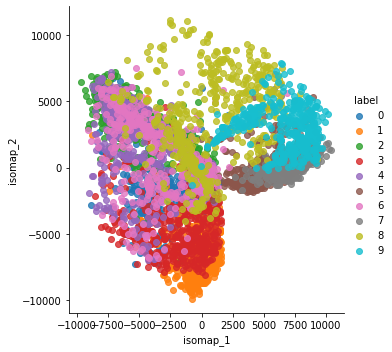

In [ ]:
# ISOPMAP(n_neighbors = 4)

from sklearn.manifold import Isomap

isomap=Isomap(n_neighbors = 4, n_components = 2, n_jobs = 4)         
X_train_isomap=isomap.fit_transform(X_train)

X_train_isomap=pd.DataFrame(X_train_isomap).loc[:,0:1]
X_train_isomap=pd.concat((X_train_isomap, y_train), axis=1) 
X_train_isomap.columns=['isomap_1', 'isomap_2', 'label']

sns.lmplot(x='isomap_1',y='isomap_2',data=X_train_isomap,hue='label',fit_reg=False)
plt.show()

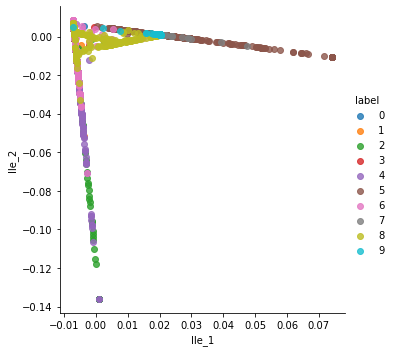

In [ ]:
# LLE(n_neighbors = 4)

from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors = 4)
X_train_lle = lle.fit_transform(X_train)

X_train_lle=pd.DataFrame(X_train_lle).loc[:,0:1]
X_train_lle=pd.concat((X_train_lle, y_train), axis=1) 
X_train_lle.columns=['lle_1', 'lle_2', 'label']
X_train_lle

sns.lmplot(x='lle_1',y='lle_2',data=X_train_lle,hue='label',fit_reg=False)
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


           0          1  label
0   3.283906  48.705200      2
1  18.202868  56.174179      4
2  28.296955  11.974874      0


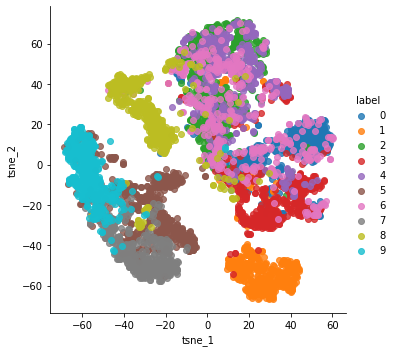

In [ ]:
# t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2) # 4미만의 공간으로
X_train_tsne = tsne.fit_transform(X_train)

X_train_tsne=pd.DataFrame(X_train_tsne)
X_train_tsne=pd.concat((X_train_tsne, y_train), axis=1) 
print(X_train_tsne.head(3))
X_train_tsne.columns=['tsne_1', 'tsne_2', 'label']

sns.lmplot(x = 'tsne_1', y = 'tsne_2', data = X_train_tsne, hue = 'label', fit_reg = False)
plt.show()

- (Q5) 시도해본 차원축소 방법 중 Fashion MNIST 데이터셋을 가장 잘 시각화하는 것으로 보이는 방법은 무엇인지 서술해보자.

t-sne 방법이 가장 데이터셋을 잘 시각화하는 것으로 보인다. 몇 개의 label이 겹치는 부분이 있지만 대체적으로 잘 분별되게 표현되었다.

- (Q6) 저차원에서 제대로 분류가 잘 되지 않는 라벨은 무엇인지 언급해보고, 왜 제대로 분류되지 않을 것인지 추측해보자.

바로 위의 plot을 보면 보라, 초록, 분홍색의 점이 상당히 겹쳐있는 것을 확인할 수있는데 이들은 2, 4, 6 label에 해당한다.

0 T-shirt/top

1 Trouser

2 Pullover

3 Dress

4 Coat

5 Sandal

6 Shirt

7 Sneaker

8 Bag

9 Ankle boot

이들 2, 4, 6 label은 T-shirt, coat, shirt를 의미하는데 이들은 모두 상의에 해당하는 옷으로 외형이 비슷하게 생겼기 때문에 분류가 잘 되지 않았다고 추측해볼 수 있다.


수고하셨습니다~